In [1]:
import numpy as np
from scipy import optimize as optimize
import matplotlib.pyplot as plt
import time

## Exercise 2.1

In [2]:
# wage, rent, utility and derivative of utility

def get_L(nvec):
    return np.sum(np.array(nvec))

def get_K(bvec):
    return np.sum(np.array(bvec))

def get_w(nvec, bvec, params):
    A, α = params
    w = (1-α) * A * (get_K(bvec)/get_L(nvec))**α
    return w

def get_r(nvec, bvec, params):
    A, α, δ = params
    r = α * A * (get_L(nvec)/get_K(bvec))**(1-α) - δ
    return r

def get_u(c, params):
    σ = params
    u = (c**(1-σ) - 1) / (1 - σ)
    return u

def get_uprime(c, params):
    σ = params
    mu = c**(-σ)
    return mu

def get_Y(nvec, bvec, params):
    A, α = params
    L = get_L(nvec)
    K = get_K(bvec)
    Y = A * K**α * L**(1 - α)
    return Y

def get_c(nvec, bvec, params):
    A, α, δ = params
    
    n1, n2, n3 = nvec
    b2, b3 = bvec
    w_params = A, α
    r_params = A, α, δ
    
    w = get_w(nvec, bvec, w_params)
    r = get_r(nvec, bvec, r_params)
    
    c1 = n1 * w - b2
    c2 = n2 * w + (1 + r) * b2 - b3
    c3 = (1 + r) * b3 + n3 * w
    
    return c1, c2, c3

In [3]:
def feasible(f_params, bvec_guess):
    b_cnstr = np.full(2, False)
    c_cnstr = np.full(3, False)
    K_cnstr = np.full(1, False)
    
    # unpack parameters
    α, β, δ, σ, A = f_params
    
    nvec = (1, 1, 0.2) # use default values as not specified
    w_params = A, α
    r_params = A, α, δ
    c_params = A, α, δ
    
    w = get_w(nvec, bvec_guess, w_params)
    r = get_r(nvec, bvec_guess, r_params)
    
    c = get_c(nvec, bvec_guess, c_params)
    
    for i in range(3):
        if c[i] < 0:
            c_cnstr[i] = True
        else:
            c_cnstr[i] = False
            
    if c_cnstr[0] == True:
        b_cnstr[0] = True
    elif c_cnstr[1] == True:
        b_cnstr = [True, True]
    elif c_cnstr[2] == True:
        b_cnstr[1] = True
    
    if get_K(bvec_guess) > 0:
        K = [True]
    
    return b_cnstr, c_cnstr, K_cnstr

In [4]:
# parameters
def f_params():
    β = 0.442
    δ = 0.6415
    σ = 3
    A = 1
    α = 0.35
    return α, β, δ, σ, A

### 2.1a

In [5]:
feasible(f_params(), [1.0, 1.2])

(array([ True, False]), array([ True, False, False]), array([False]))

Nonnegativity constraint of c1 is violated, likely to be caused by b2

### 2.1b

In [6]:
feasible(f_params(), [0.06, -0.001])

(array([False, False]), array([False, False, False]), array([False]))

No constraint is violated

### 2.1c

In [7]:
feasible(f_params(), [0.1, 0.1])

(array([False, False]), array([False, False, False]), array([False]))

No constraint is violated

## Exercise 2.2

In [54]:
def eqbm(bvec, w, r, params):

    β, σ, nvec, L, A, α, δ, SS_tol = params
    
    w_params = A, α
    r_params = A, α, δ
    c_params = A, α, δ
    
    w = get_w(nvec, bvec, w_params)
    r = get_r(nvec, bvec, r_params)
    
    c1bar, c2bar, c3bar = get_c(nvec, bvec, c_params)
    
    mu1 = get_uprime(c1bar, σ)
    mu2 = get_uprime(c2bar, σ)
    mu3 = get_uprime(c3bar, σ)
    print(mu1,mu2,mu3)
    
    f1 = mu1 - β * (1 + r) * mu2
    f2 = mu2 - β * (1 + r) * mu3

    return f1, f2

In [55]:
eqbm(b_ss, w_ss, r_ss, params1())

164.75510252676185 108.57626920752709 71.55351217793152


(-1.3926637620897964e-12, 2.6290081223123707e-12)

In [9]:
def get_SS(params, bvec_guess, SS_graphs = True):
    
    #start time
    start_time = time.time()
    
    #unpack parameters
    β, σ, nvec, L, A, α, δ, SS_tol = params
    
    w_params = A, α
    r_params = A, α, δ
    c_params = A, α, δ
    Y_params = A, α
    
    w = get_w(nvec, bvec_guess, w_params)
    r = get_r(nvec, bvec_guess, r_params)
    
    #find root
    b_ss = optimize.fsolve(eqbm, bvec_guess, args = (w, r, params), xtol = SS_tol)
    b2bar, b3bar = b_ss
    
    #compute all steady state variables
    c_ss = get_c(nvec, b_ss, c_params)
    w_ss = get_w(nvec, b_ss, w_params)
    r_ss = get_r(nvec, b_ss, r_params)
    K_ss = get_K(b_ss)
    Y_ss = get_Y(nvec, b_ss, Y_params)
    C_ss = np.sum(c_ss)
    EulErr_ss = eqbm(b_ss, w_ss, r_ss, params)
    RCerr_ss = Y_ss - C_ss - δ * K_ss
    ss_time = time.time() - start_time
    
    if SS_graphs == True:
        plt.figure(figsize = (7,7))
        plt.plot([2,3], b_ss, '-o', label = 'savings')
        plt.plot([1,2,3], c_ss, '-o', label = 'consumption')
        plt.xlabel('age')
        plt.xticks([1,2,3])
        plt.ylabel('savings and consumption')
        plt.title('savings and consumption vs. age')
        plt.legend()
        plt.grid()
        plt.show()
    
    results = dict({'b_ss': b_ss, 'c_ss': c_ss, 'w_ss': w_ss, 'r_ss': r_ss, 
                    'K_ss': K_ss, 'Y_ss': Y_ss, 'C_ss': C_ss,
                    'EulErr_ss': EulErr_ss, 'RCerr_ss': RCerr_ss,
                    'ss_time': ss_time})
    return results

### 2.2a and b

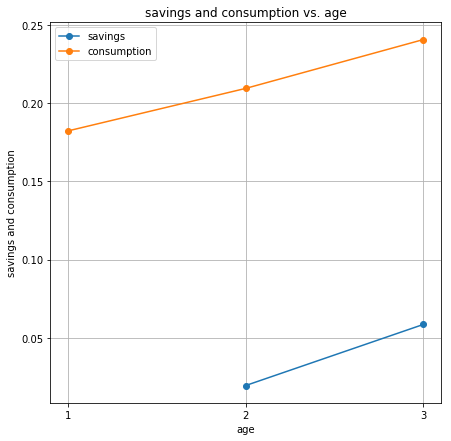

{'b_ss': array([0.01931253, 0.0584111 ]),
 'c_ss': (0.18241212755849867, 0.20961468030898922, 0.24087386507209851),
 'w_ss': 0.20172465739052575,
 'r_ss': 2.433062339127069,
 'K_ss': 0.07772362575316386,
 'Y_ss': 0.6827603788602411,
 'C_ss': 0.6329006729395864,
 'EulErr_ss': (-1.3926637620897964e-12, 2.6290081223123707e-12),
 'RCerr_ss': 8.326672684688674e-17,
 'ss_time': 0.003229856491088867}

In [39]:
def params1():
    β = 0.442
    δ = 0.6415
    σ = 3
    A = 1
    α = 0.35
    nvec = np.array([1, 1, 0.2])
    L = np.sum(nvec)
    SS_tol = 1e-8
    return β, σ, nvec, L, A, α, δ, SS_tol

bvec_guess = [0.1, 0.1]

ss1 = get_SS(params1(), bvec_guess)
ss1

### 2.2c

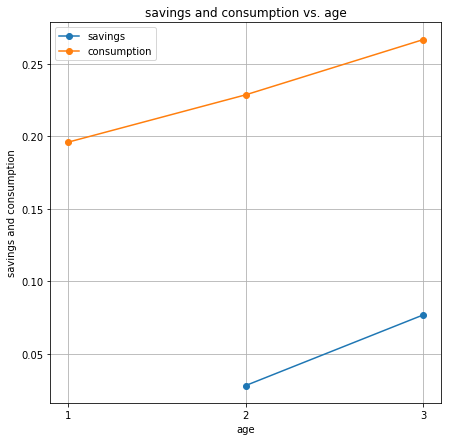

{'b_ss': array([0.02817692, 0.07686545]),
 'c_ss': (0.19597527701928497, 0.2286159413839988, 0.26669307195186887),
 'w_ss': 0.22415219593446706,
 'r_ss': 1.8863765057189819,
 'K_ss': 0.1050423702259807,
 'Y_ss': 0.7586689708551193,
 'C_ss': 0.6912842903551526,
 'EulErr_ss': (6.87805368215777e-12, 2.5295321393059567e-12),
 'RCerr_ss': 9.71445146547012e-17,
 'ss_time': 0.0017828941345214844}

In [11]:
def params2():
    β = 0.55
    δ = 0.6415
    σ = 3
    A = 1
    α = 0.35
    nvec = np.array([1, 1, 0.2])
    L = np.sum(nvec)
    SS_tol = 1e-8
    return β, σ, nvec, L, A, α, δ, SS_tol

bvec_guess = [0.1, 0.1]

ss2 = get_SS(params2(), bvec_guess)
ss2

In [38]:
difference = dict()
for i in ss1.keys():
    difference[i] = np.array(ss2[i]) - np.array(ss1[i])
difference

{'b_ss': array([0.00886439, 0.01845436]),
 'c_ss': array([0.01356315, 0.01900126, 0.02581921]),
 'w_ss': 0.022427538543941306,
 'r_ss': -0.5466858334080873,
 'K_ss': 0.027318744472816847,
 'Y_ss': 0.0759085919948782,
 'C_ss': 0.05838361741556619,
 'EulErr_ss': array([ 8.27071744e-12, -9.94759830e-14]),
 'RCerr_ss': 1.3877787807814457e-17,
 'ss_time': -0.0009660720825195312}

Everything increases except rent.  
This can be interpreted as ...  
I think that the exogenous labour supply plays a part...

## Exercise 2.3
Time path iteration:  
- Step 1: solve for steady state, finished in 2.2
- Step 2: guess $T = 50$
- Step 3: guess 
$$K^i = (K_1^i, ... , K_T^i) = (1, ..., 1)$$
$$r^i = (r_1^i, ... , r_T^i) = (1, ..., 1)$$
$$w^i = (w_1^i, ... , w_T^i) = (1, ..., 1)$$
- Step 4: Solve household problem, solution as $(b_{2, t+1}, b_{3, t+1})_{t=1}^T$
- Step 5: update capital stock, check $\sum||K^{i'}-K^i|| \leq \epsilon$, if not, update $K^{i+1} = \xi K^{i'} + (1-\xi) K^i$

In [78]:
# Step 1:
b_ss = ss1['b_ss']
K_ss = ss1['K_ss']
r_ss = ss1['r_ss']
w_ss = ss1['w_ss']

In [79]:
# Step 2:
def guessT():
    return 50

In [80]:
# Step 3:
def guessK(T, b_init):
    
    K0 = get_K(b_init)
    K_init = np.linspace(K0, K_ss, T)

    return K_init

def get_w_with_K(K, params):
    
    # unpack params
    β, σ, nvec, L, A, α, δ, SS_tol = params
    
    w = (1-α) * A * (K/L)**α
    
    return w

def get_r_with_K(K, params):
    
    # unpack params
    β, σ, nvec, L, A, α, δ, SS_tol = params
    
    r = α * A * (L/K)**(1-α) - δ
    return r

In [81]:
# Step 4:
def Euler_old(b32, bvec, r1, r2, w1, w2, params):
    
    # unpack params
    β, σ, nvec, L, A, α, δ, SS_tol = params
    b21, b31 = bvec
    n1, n2, n3 = nvec
    
    # marginal utilities
    mu2 = get_uprime(w1 * n2 + (1 + r1) * b21 - b32, α)
    mu3 = get_uprime(w2 * n3 + (1 + r2) * b32, α)
    
    # Euler in the first period, for middle-aged.
    f3 = mu2 - β * (1 + r2) * mu3
        
    return f3

def Euler_young(new_twisted_b, bvec, b32, r3, w3, params):
    
    # unpack params
    b22, b33 = new_twisted_b
    β, σ, nvec, L, A, α, δ, SS_tol = params
    n1, n2, n3 = nvec
    
    # pack params
    w_params = A, α
    r_params = A, α, δ
    
    # w2 and r2
    w1 = get_w(nvec, bvec, w_params)
    w2 = get_w(nvec, [b22, b32], w_params)
    r2 = get_r(nvec, [b22, b32], r_params)
    
    # Euler other than first period, for young-aged.
    mu1 = get_uprime(w1 * n1 - b22, σ)
    mu2 = get_uprime(w2 * n2 + (1 + r2) * b22 - b33, σ)
    mu3 = get_uprime(w3 * n3 + (1 + r3) * b33, σ)
    
    # Euler equations
    f1 = mu1 - β * (1 + r2) * mu2
    f2 = mu2 - β * (1 + r3) * mu3
    
    return np.array([f1, f2])

def iteration_first(bvec, r1, r2, w1, w2, params):
    # if we are at the very first period
    
    # unpack params
    β, σ, nvec, L, A, α, δ, SS_tol = params
    b32 = bvec[1]
    
    b32 = float(optimize.fsolve(Euler_old, b32, args = (bvec, r1, r2, w1, w2, params), xtol = SS_tol))
    b21 = bvec[0]
    twisted_b = np.array([b21, b32])
    
    return twisted_b

def one_iteration(twisted_b, b31, r3, w3, params):
    # if not at first period
    
    # unpack params
    β, σ, nvec, L, A, α, δ, SS_tol = params
    
    
    b21, b32 = twisted_b
    bvec = np.array([b21, b31])
    new_twisted_b = optimize.fsolve(Euler_young, twisted_b, args = (bvec, b32, r3, w3, params), xtol = SS_tol)
    
    return new_twisted_b

def one_TPI(T, w, r, b_init, K_old, params):
    K_new = np.copy(K_old)
    for i in range(T):
        if i == 0: # in the very first period
            old_twisted_b = iteration_first(b_init, r[0], r[1], w[0], w[1], params)
            b31 = b_init[1]
        # then, in all periods
        new_twisted_b = one_iteration(old_twisted_b, b31, r[i+1], w[i+1], params)
        b_current = [new_twisted_b[0], old_twisted_b[1]]
#         print(b_current)
        b31 = b_current[1]
        K_current = get_K(b_current)
        K_new[i] = K_current 
        old_twisted_b = new_twisted_b
        
    return K_new

In [84]:
def l2diff(K_new, K_old):
    K_new = K_new[:49:]
    L_old = K_old[:49:]
    diff = 0.0
    for i in range(len(K_new)):
        norm = (K_new[i] - K_old[i])**2
        diff += norm
    
    diff = np.sqrt(diff)
    return diff

def iterate(T, ξ, tol, maxiter, params):
    
    # unpack params
    β, σ, nvec, L, A, α, δ, SS_tol = params
    
    # initialize
    b_init = [0.8 * b_ss[0], 1.1 * b_ss[1]]

    K_init = guessK(T+1, b_init)
    w = get_w_with_K(K_init, params)
    r = get_r_with_K(K_init, params)
    
    K_new = K_init
    K_old = K_init
    
    diff = np.inf
    i = 0
    while diff > tol:

        K_new = one_TPI(T, w, r, b_init, K_old, params)
        w = get_w_with_K(K_new, params)
        r = get_r_with_K(K_new, params)

        diff = l2diff(K_new, K_old)

        i += 1
        K_old = ξ * K_new + (1 - ξ) * K_old
        
        if i > maxiter:
            print("did not converge within {} iterations".format(maxiter))
            break
    
    return K_new

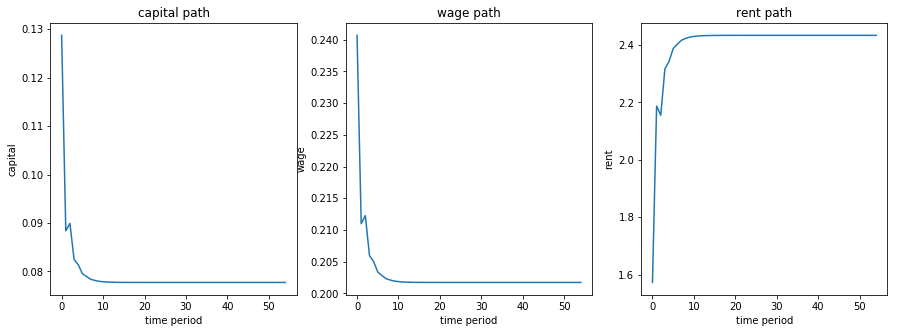

In [93]:
Kpath = np.hstack((iterate(guessT(), 0.1, 1e-5, 100, params1()),np.array([K_ss, K_ss, K_ss, K_ss])))
T_grid = list(range(len(Kpath)))
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (15,5))
# capital path
ax1.plot(T_grid, Kpath, label = 'capital')
ax1.set_title('capital path')
ax1.set_xlabel('time period')
ax1.set_ylabel('capital')
# wage path
ax2.plot(T_grid, get_w_with_K(Kpath, params1()), label = 'wage')
ax2.set_title('wage path')
ax2.set_xlabel('time period')
ax2.set_ylabel('wage')
# rent path
ax3.plot(T_grid, get_r_with_K(Kpath, params1()), label = 'rent')
ax3.set_title('rent path')
ax3.set_xlabel('time period')
ax3.set_ylabel('rent')
plt.show()